**2D nonlinear diffusion-reaction system**

In [21]:
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
from sys import stderr
from scipy import stats
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.interpolate import griddata
from matplotlib.pyplot import scatter, figure
from torch.utils.data import TensorDataset, DataLoader

seed = 42
batch_size = 100
noise_scale = 0.01
num_samples = 100
num_sensors = 100

np.random.seed(seed)
torch.manual_seed(seed)

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(4, 4)})

class Experiment(nn.Module):
    def __init__(self):
        super(Experiment, self).__init__()

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        print(self.device)

        self.optimizer = None
        self.train_loss_history = []
        self.w_int = 1
        self.w_data = 1
        self.w_bc = 1
        self.w_param_std = 1
        self.numInputs = 2
        self.numParams = 1
        self.numOutputs = 2
        self.hidden_size = 50

        # Initialize history variables
        self.total_loss_history = []
        self.loss_interior_history = []
        self.loss_data_history = []
        self.loss_bc_history = []
        self.loss_std_history = []

        self.predicted_params = torch.zeros((batch_size,self.numParams), requires_grad=True, device=self.device)

        # We have 2 input feature
        self.b1 = nn.Linear(self.numInputs, self.hidden_size).to(self.device)
        self.b2 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.b3 = nn.Linear(self.hidden_size, self.numOutputs).to(self.device)

        self.t1 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.t2 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.t3 = nn.Linear(self.hidden_size, self.numParams).to(self.device)


    def create_dataset(self, noise_scale=0.01, num_samples=100, lambd=0.01, k=1.0, device=None, batch_size=100):
        if device is None:
            device = self.device

        # Generate x and y points evenly spaced between -1 and 1
        x = torch.linspace(-1, 1, num_samples, device=device)  # Space domain for x
        y = torch.linspace(-1, 1, num_samples, device=device)  # Space domain for y

        x_grid, y_grid = torch.meshgrid(x, y, indexing="ij")
        u = exact_solution(x_grid, y_grid)
        f = source_term(x_grid, y_grid)

        self.indices = np.random.choice(x_grid.numel(), num_samples, replace=False)

        # Extract sensor locations and their corresponding u and f values
        self.sensor_x = x_grid.reshape(-1)[self.indices]
        self.sensor_y = y_grid.reshape(-1)[self.indices]
        self.sensor_u = (u.reshape(-1)[self.indices] + torch.randn(num_samples, device=device) * noise_scale)
        self.sensor_f = (f.reshape(-1)[self.indices] + torch.randn(num_samples, device=device) * noise_scale)

        # Optional: Plot the u and f distribution with sensor locations
        plot_u_f_distribution(x_grid, y_grid, u, f, self.sensor_x, self.sensor_y)


    def forward(self, x, y):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x).float().to(self.device)

        if not torch.is_tensor(y):
            y = torch.from_numpy(y).float().to(self.device)


        # Add a dimension if it's not already there
        x = x.unsqueeze(1) if x.dim() == 1 else x
        y = y.unsqueeze(1) if y.dim() == 1 else y


        input = torch.cat((x, y), 1)
        h1 = torch.tanh(self.b1(input))
        h2 = torch.tanh(self.b2(h1))

        prior_param_sample = torch.rand(batch_size, self.hidden_size , device=self.device).requires_grad_(True)

        t1 = torch.tanh(self.t1(prior_param_sample))
        t2 = torch.tanh(self.t2(t1))
        posterior_param_sample = self.t3(t2)
        self.predicted_params = posterior_param_sample

        output = self.b3(torch.multiply(t2, h2))

        # Split the output into u and f, each of shape [100]
        u = output[:, 0]
        f = output[:, 1]

        return u, f


    # General formula to compute the n-th order derivative of y = f(x) with respect to x
    def compute_derivative(self, y, x, n):
        if n == 0:
            return y
        else:
            dy_dx = torch.autograd.grad(y, x, torch.ones_like(y, device= self.device),
                                        create_graph=True, retain_graph=True,
                                        allow_unused=True)[0]
        return self.compute_derivative(dy_dx, x, n - 1)


    def PDE_residual(self, x, y, lambd=0.01):
        u, f = self.forward(x, y)
        du_dx = self.compute_derivative(u, x, 1)
        du_dy = self.compute_derivative(u, y, 1)
        d2u_dx2 = self.compute_derivative(u, x, 2)
        d2u_dy2 = self.compute_derivative(u, y, 2)
        u_squared = u ** 2  # Shape [100]
        u_squared = u_squared.view(-1, 1)

        # residual = lambda(d2u_dx2 + d2u_dy2) + k * (u**2) + f
        residual = torch.multiply(lambd, (d2u_dx2 + d2u_dy2)).view(-1, 1) + torch.multiply(self.predicted_params, u_squared) + f.view(-1, 1)
        return residual


    def loss_boundary_condition(self, num_samples=100):
        num_sensors_per_side = 25
        points = torch.linspace(-1, 1, num_sensors_per_side, device = self.device)

        x_bottom, y_bottom = points, -torch.ones(num_sensors_per_side, device = self.device)
        x_top, y_top = points, torch.ones(num_sensors_per_side, device = self.device)
        x_left, y_left = -torch.ones(num_sensors_per_side, device = self.device), points
        x_right, y_right = torch.ones(num_sensors_per_side, device = self.device), points

        # Concatenating all x and y coordinates
        all_x = torch.cat([x_bottom, x_top, x_left, x_right])
        all_y = torch.cat([y_bottom, y_top, y_left, y_right])

        loss, _ = self.forward(all_x, all_y)
        boundary_loss = torch.abs(loss).sum()

        return boundary_loss


    def loss_data(self):
        u_pred, f_pred = self.forward(self.sensor_x, self.sensor_y)
        loss_u = torch.mean(torch.square(u_pred - self.sensor_u))
        loss_f = torch.mean(torch.square(f_pred - self.sensor_f))
        return loss_u + loss_f



    def loss_interior(self, num_samples=100):
        interior_x_samples = 2*torch.rand((num_samples, 1), device=self.device).requires_grad_(True)  - 1.0
        interior_y_samples = 2*torch.rand((num_samples, 1), device=self.device).requires_grad_(True)  - 1.0
        res = self.PDE_residual(interior_x_samples, interior_y_samples)
        loss_residual = torch.mean(torch.square(res))
        return loss_residual


    def compute_losses(self):
        loss_interior = self.loss_interior()
        loss_data = self.loss_data()
        loss_bc = self.loss_boundary_condition()
        return loss_interior, loss_data, loss_bc


    def sample_parameter_posterior(self, num_samples=100):
        prior_param_samples = torch.rand(num_samples, self.hidden_size, device=self.device).requires_grad_(True)
        t1 = torch.tanh(self.t1(prior_param_samples))
        t2 = torch.tanh(self.t2(t1))
        posterior_param_samples = self.t3(t2)
        return posterior_param_samples


    def update_predicted_params(self, posterior_samples):
        mean = torch.mean(posterior_samples, dim=0)  # Compute the mean along the first axis
        std = torch.std(posterior_samples, dim=0)    # Compute the standard deviation along the first axis

        self.predicted_params = posterior_samples
        self.mean_predicted_params = mean  # Store the mean
        self.std_params = std  # Attach the standard deviation as an attribute


    def closure(self):
        self.optimizer.zero_grad()
        loss_interior, loss_data, loss_bc = self.compute_losses()
        total_loss = self.w_int * loss_interior \
                   + self.w_data * loss_data \
                   + self.w_bc * loss_bc

        # Sample the parameter posterior and update self.predicted_params and self.std_params
        posterior_samples = self.sample_parameter_posterior(num_samples=100)
        self.update_predicted_params(posterior_samples)

        # Add the (Log(std))**2 term to the loss with the specified weight
        self.log_std_squared_loss = self.w_param_std * torch.mean(torch.log(self.std_params)**2)
        total_loss += self.log_std_squared_loss

        total_loss.backward(retain_graph=True)
        return total_loss


    def train(self, epochs, optimizer='Adam', num_samples=100, **kwargs):
        if optimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), **kwargs)

        elif optimizer == 'L-BFGS':
            self.optimizer = torch.optim.LBFGS(self.parameters(), **kwargs)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=3, verbose=True)


        # Training loop
        for epoch in range(epochs):
            self.optimizer.step(self.closure)
            if epoch % 1000 == 0:
                loss_interior, loss_data, loss_bc = self.compute_losses()
                total_loss = loss_interior + loss_data + loss_bc

                scheduler.step(total_loss)

                # Append losses to history
                self.total_loss_history.append(total_loss.item())
                self.loss_interior_history.append(loss_interior.item())
                self.loss_data_history.append(loss_data.item())
                self.loss_bc_history.append(loss_bc.item())
                self.loss_std_history.append(self.log_std_squared_loss.item())

                print(f'Epoch({optimizer}):{epoch},  Total Loss:{total_loss.item():.2f}  ' \
                        f'PDE Loss:{loss_interior.item():.2f}  ' \
                        f'BC Loss:{loss_bc.item():.2f}  ' \
                        f'Data Loss: {loss_data.item():.2f}  ' \
                        f'Mean Predicted Param 1: {self.mean_predicted_params[0]:.2f} ' \
                        f'Std Params:{self.std_params.detach().cpu().numpy()[0]:.2f}  ' \
                        f'Std Log Loss:{self.log_std_squared_loss.item():.2f}')

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

cuda:0


In [23]:
# exact solution
def exact_solution(x, y):
    return torch.sin(torch.pi * x) * torch.sin(torch.pi * y)

# function f
def source_term(x, y, lambd=0.01, k=1.0):
    u = exact_solution(x, y)
    f = -1/50.0 * torch.pi**2 * (u) + u**2
    return f

In [24]:
def plot_u_f_distribution(x_grid, y_grid, u, f, sensor_x, sensor_y):
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # Subplot for 'u'
    contour1 = axes[0].contourf(x_grid.cpu().detach().numpy(), y_grid.cpu().detach().numpy(), u.cpu().detach().numpy(), cmap='jet', levels=40, vmin=-1, vmax=1)
    scatter_u = axes[0].scatter(sensor_x.cpu().detach().numpy(), sensor_y.cpu().detach().numpy(), cmap='jet', facecolors='none', marker='o', edgecolor='black', s=40, linewidths=2, label="training sample for u")
    fig.colorbar(contour1, ax=axes[0])
    axes[0].set_title('Distribution of u')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True)

    # Subplot for 'f'
    contour2 = axes[1].contourf(x_grid.cpu().detach().numpy(), y_grid.cpu().detach().numpy(), f.cpu().detach().numpy(), cmap='jet', levels=40, vmin=0, vmax=1)
    scatter_f = axes[1].scatter(sensor_x.cpu().detach().numpy(), sensor_y.cpu().detach().numpy(),  cmap='jet', color='black', marker='x', s=40, linewidths=2, label="training sample for s")
    fig.colorbar(contour2, ax=axes[1])
    axes[1].set_title('Distribution of f')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True)

    plt.tight_layout()
    plt.show()

In [25]:
def make_plot(model, device=device):
    # Generate test data
    num_test_samples = 100
    x_test = torch.linspace(-1, 1, num_test_samples, device=device)
    y_test = torch.linspace(-1, 1, num_test_samples, device=device)
    x_grid, y_grid = torch.meshgrid(x_test, y_test, indexing="ij")

    x_flat = x_grid.reshape(-1)
    y_flat = y_grid.reshape(-1)

    u_preds = []
    f_preds = []

    # Process in batches
    batch_size = 100
    num_batches = (x_flat.size(0) + batch_size - 1) // batch_size  # Calculate the number of batches needed

    model.eval()
    with torch.no_grad():
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min(start_idx + batch_size, x_flat.size(0))

            # Slice the batch
            x_batch = x_flat[start_idx:end_idx]
            y_batch = y_flat[start_idx:end_idx]

            # Predict for this batch
            u_pred, f_pred = model.forward(x_batch, y_batch)

            # Collect predictions
            u_preds.append(u_pred)
            f_preds.append(f_pred)

    # Concatenate all batched predictions
    u_preds = torch.cat(u_preds, dim=0)
    f_preds = torch.cat(f_preds, dim=0)

    # Reshape predictions to match the grid shape
    u_preds = u_preds.view(num_test_samples, num_test_samples)
    f_preds = f_preds.view(num_test_samples, num_test_samples)

    # Compute the exact solutions for comparison
    u_exact = exact_solution(x_grid, y_grid)
    f_exact = source_term(x_grid, y_grid)

    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot predicted 'u'
    contour1 = axes[0, 0].contourf(x_grid.cpu().numpy(), y_grid.cpu().numpy(), u_preds.cpu().numpy(), cmap='jet', levels=40)
    fig.colorbar(contour1, ax=axes[0, 0])
    axes[0, 0].set_title('Predicted u')
    axes[0, 0].set_xlabel('x')
    axes[0, 0].set_ylabel('y')

    # Plot exact 'u'
    contour2 = axes[0, 1].contourf(x_grid.cpu().numpy(), y_grid.cpu().numpy(), u_exact.cpu().numpy(), cmap='jet', levels=40)
    fig.colorbar(contour2, ax=axes[0, 1])
    axes[0, 1].set_title('Exact u')
    axes[0, 1].set_xlabel('x')
    axes[0, 1].set_ylabel('y')

    # Plot predicted 'f'
    contour3 = axes[1, 0].contourf(x_grid.cpu().numpy(), y_grid.cpu().numpy(), f_preds.cpu().numpy(), cmap='jet', levels=40)
    fig.colorbar(contour3, ax=axes[1, 0])
    axes[1, 0].set_title('Predicted f')
    axes[1, 0].set_xlabel('x')
    axes[1, 0].set_ylabel('y')

    # Plot exact 'f'
    contour4 = axes[1, 1].contourf(x_grid.cpu().numpy(), y_grid.cpu().numpy(), f_exact.cpu().numpy(), cmap='jet', levels=40)
    fig.colorbar(contour4, ax=axes[1, 1])
    axes[1, 1].set_title('Exact f')
    axes[1, 1].set_xlabel('x')
    axes[1, 1].set_ylabel('y')

    plt.tight_layout()
    plt.show()


In [26]:
net = Experiment()
net.to(net.device)
print("Params:", sum(p.numel() for p in net.parameters() if p.requires_grad))

cuda:0
Params: 7953


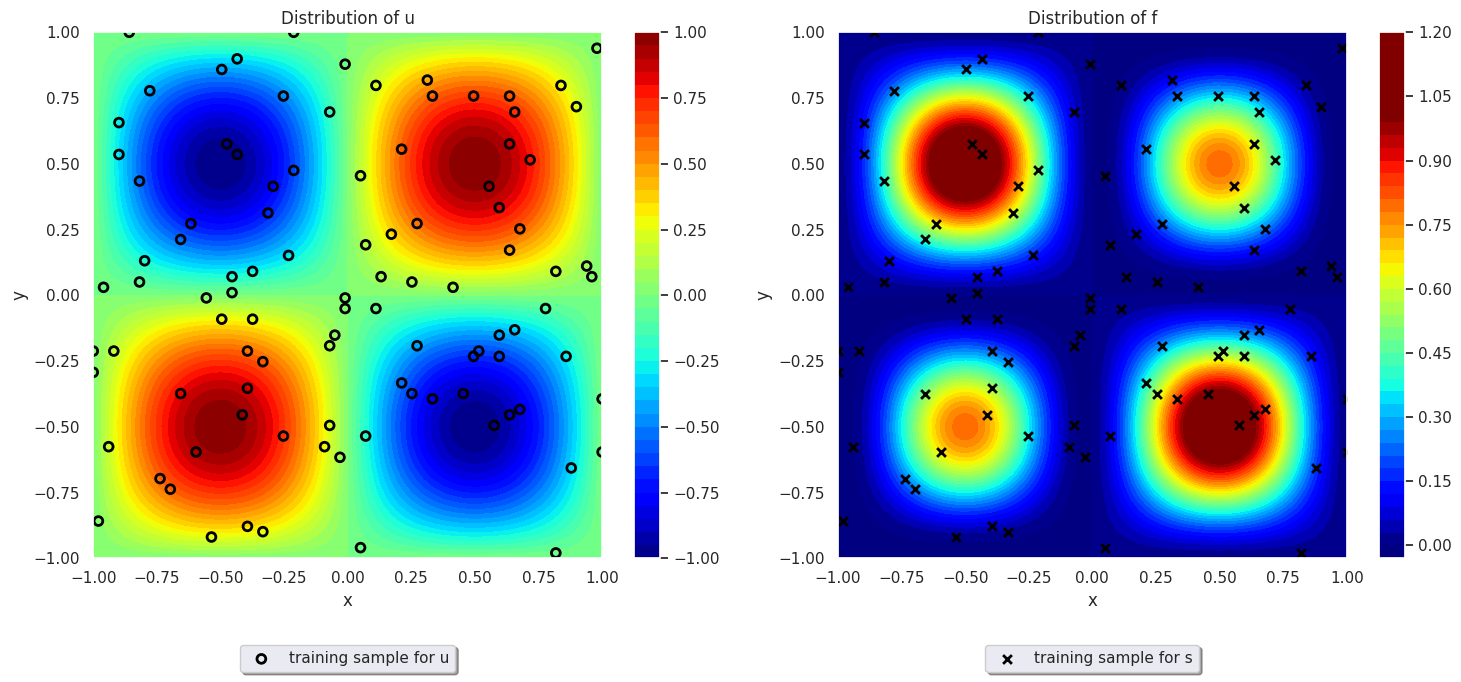

In [27]:
net.create_dataset(device = net.device, batch_size=batch_size)

In [28]:
net.w_int = 1
net.w_data = 10
net.w_bc   = 1
net.w_param_std = 0

In [29]:
torch.autograd.set_detect_anomaly(True)
net.train(20000, optimizer='Adam', lr=1e-3)

Epoch(Adam):0,  Total Loss:6.45  PDE Loss:0.02  BC Loss:6.08  Data Loss: 0.35  Mean Predicted Param 1: 0.15 Std Params:0.03  Std Log Loss:0.00
Epoch(Adam):1000,  Total Loss:0.47  PDE Loss:0.06  BC Loss:0.09  Data Loss: 0.33  Mean Predicted Param 1: 0.02 Std Params:0.03  Std Log Loss:0.00
Epoch(Adam):2000,  Total Loss:0.40  PDE Loss:0.05  BC Loss:0.02  Data Loss: 0.33  Mean Predicted Param 1: 0.03 Std Params:0.03  Std Log Loss:0.00
Epoch(Adam):3000,  Total Loss:0.42  PDE Loss:0.05  BC Loss:0.04  Data Loss: 0.33  Mean Predicted Param 1: -0.01 Std Params:0.03  Std Log Loss:0.00
Epoch(Adam):4000,  Total Loss:0.39  PDE Loss:0.05  BC Loss:0.02  Data Loss: 0.32  Mean Predicted Param 1: -0.63 Std Params:0.03  Std Log Loss:0.00
Epoch(Adam):5000,  Total Loss:0.45  PDE Loss:0.11  BC Loss:0.06  Data Loss: 0.28  Mean Predicted Param 1: -2.87 Std Params:0.03  Std Log Loss:0.00
Epoch(Adam):6000,  Total Loss:0.38  PDE Loss:0.10  BC Loss:0.02  Data Loss: 0.27  Mean Predicted Param 1: -7.08 Std Params:0

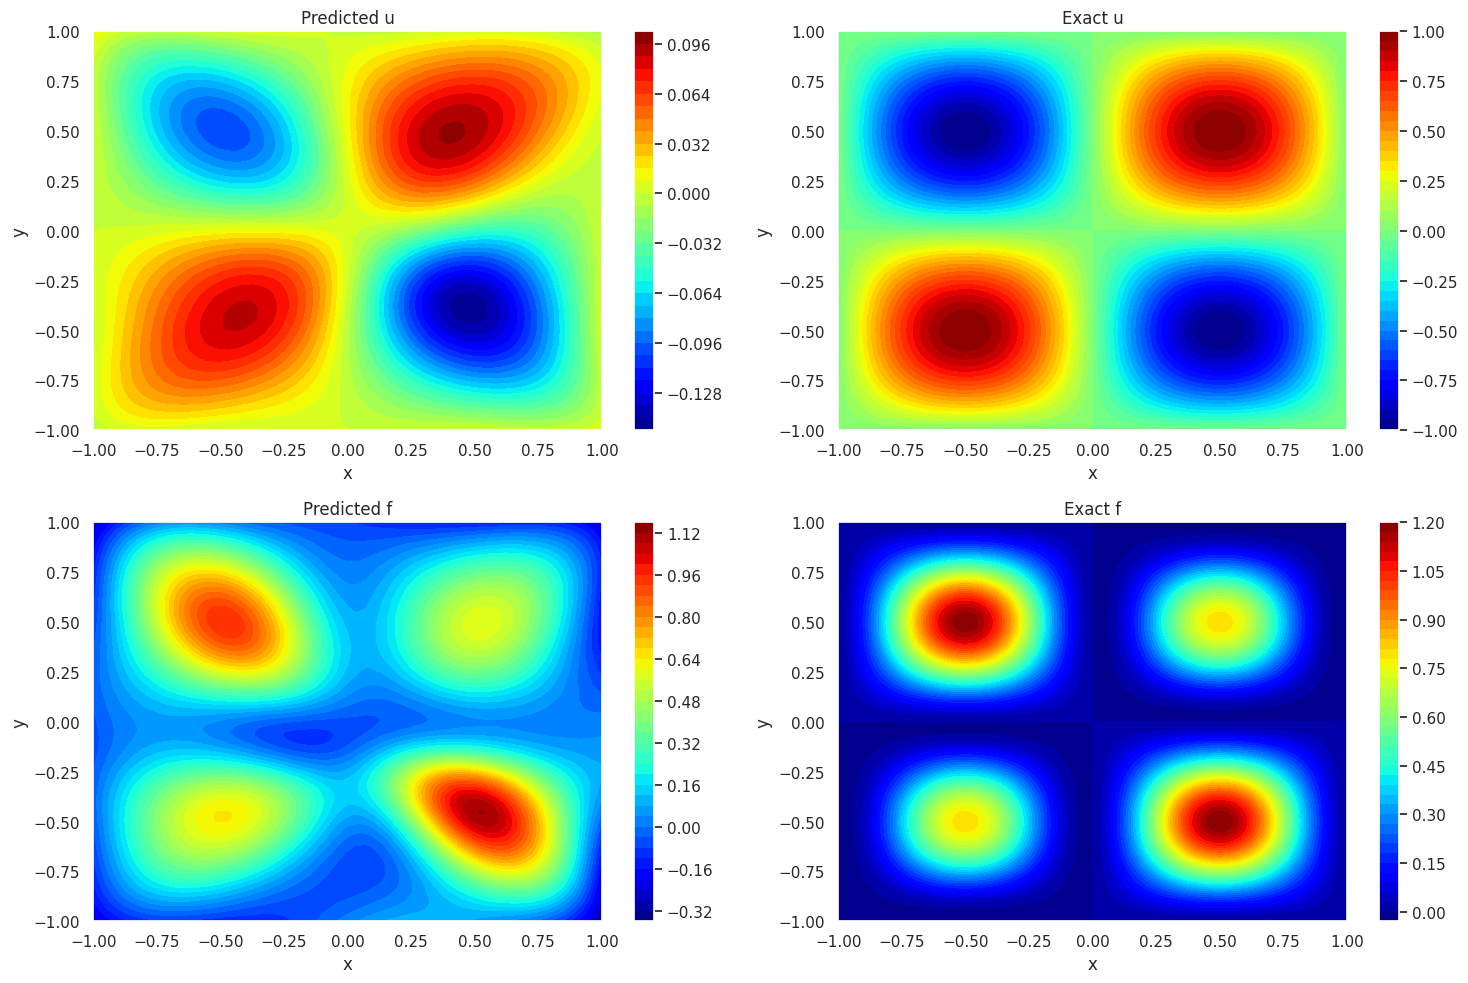

In [30]:
make_plot(net, device=net.device)